# Data Structures in cluster_generator

---

In the Quickguides, we've shown off a lot of the bells and whistles of ``cluster_generator``, but for a more in-depth user, more detail may be required. This guide will discuss the core data structures in the ``cluster_generator`` package and how to interact with them.

## Contents
- [Data Structures](#Data-Structures)
  - [RadialProfiles](#Radial-Profiles)
    - [Accessing / Using Existing Profiles](#Accessing-and-Using-Existing-Profiles)
    - [Creating Profiles](#Creating-Profiles)
    - [IO Operations](#I/O-Operations-on-RadialProfiles)
  - [Gravity](#Gravity)
  - [ClusterModel](#ClusterModel)
    - [VirialEquilibrium](#VirialEquilibrium)
    - [Generating Particles](#Generating-Particles)
  - [ClusterParticles](#ClusterParticles)
  - [ClusterICs](#ClusterICs)
    - [Inside ClusterICs](#Inside-ClusterICs)

---

## Data Structures
The ``cluster_generator`` package comes with a lot of different classes which can be a bit confusing to manage. In this guide, we are going to go through the 5 major classes in the package and describe their usage in most cases. For more concrete details on all of the classes discussed, check out the API documentation.

### Radial Profiles
Radial profiles are the underlying equations describing measurable quantities like density, entropy, temperature, etc. There are a wide array of available ``RadialProfile`` objects built into the ``cluster_generator`` software, and it is easy to set up custom ones.

#### Accessing and Using Existing Profiles

In [2]:
import cluster_generator as cg
import numpy as np
import matplotlib.pyplot as plt
# Look at the built-in options #
print(f"There are {len(cg.radial_profiles.RadialProfile.builtin)} profiles built in: {cg.radial_profiles.RadialProfile.builtin}.")

There are 25 profiles built in: ['constant_profile', 'power_law_profile', 'beta_model_profile', 'hernquist_density_profile', 'cored_hernquist_density_profile', 'hernquist_mass_profile', 'nfw_density_profile', 'nfw_mass_profile', 'tnfw_density_profile', 'tnfw_mass_profile', 'snfw_density_profile', 'snfw_mass_profile', 'cored_snfw_density_profile', 'cored_snfw_mass_profile', 'cored_snfw_total_mass', 'einasto_density_profile', 'einasto_mass_profile', 'am06_density_profile', 'vikhlinin_density_profile', 'vikhlinin_temperature_profile', 'am06_temperature_profile', 'baseline_entropy_profile', 'broken_entropy_profile', 'walker_entropy_profile', 'rescale_profile_by_mass'].


You can create any one of these profiles by one of two methods:

In [3]:
# -- direct calling -- #
profile_example = cg.radial_profiles.nfw_density_profile(1e7,1000)
other_profile_example = cg.radial_profiles.RadialProfile.built_in("nfw_density_profile",1e7,1000)

print(profile_example,other_profile_example)

RadialProfile; type=nfw_density_profile. RadialProfile; type=nfw_density_profile.


``RadialProfile`` objects are just wrappers for standard functions with some additional functionality. You can operate on them just as you would any other objects, and the functions will automatically be summed behind the scenes. The base function is stored in the ``RadialProfile.profile`` attribute, and can be accessed directly if necessary.

The ``RadialProfile`` object has a few additional methods that are useful. You can add a core or truncate a profile with ``.add_core`` and ``.cutoff`` respectively. For example,

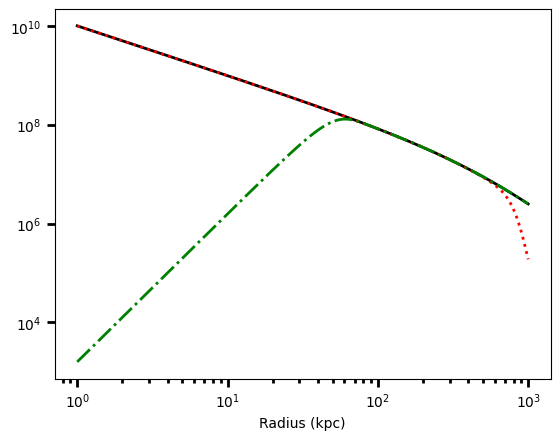

In [4]:
# - plot the original - #
fig,ax = plt.subplots(1,1)
profile_example.plot(1,1000,1000,fig=fig,ax=ax,color="k",ls="-")

# - truncate the profile - #
t_profile = profile_example.cutoff(800)
t_profile.plot(1,1000,1000,fig=fig,ax=ax,color="red",ls=":")

# - add a core - #
c_profile = profile_example.add_core(50,4)
c_profile.plot(1,1000,1000,fig=fig,ax=ax,color="green",ls="-.")

plt.show()

---

#### Creating Profiles

Okay, so we've seen how to play around with the existing profiles, but what if I want to use my own profile? How do I make it a ``RadialProfile`` object? 

There are two methods by which you can do this depending on what you already have. If you already have a ``callable`` object (function, lambda function, etc.) then you can simply call the class with the function as the argument. If you have raw data, you should use the ``.from_array`` method. Below is an example of each:

RadialProfile; type=sine. RadialProfile; type=cosine.


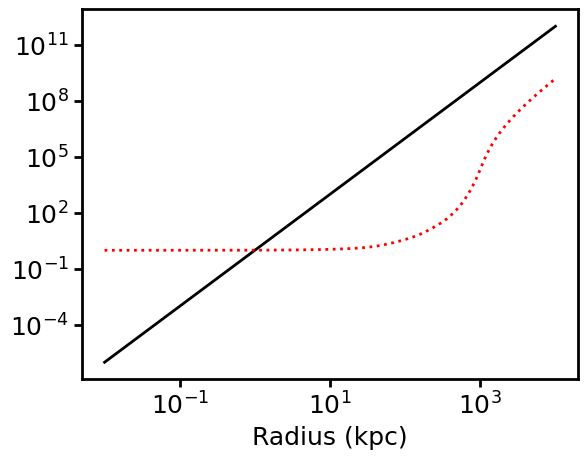

In [5]:
# -- Creating a profile with a function -- #
profile_1 = cg.radial_profiles.RadialProfile(lambda x: x**3,name="sine")

# -- creating a profile from data -- #
x = np.geomspace(1,1000,1000)
y = (x/100)**2 + np.exp(x/100)

profile_2 = cg.radial_profiles.RadialProfile.from_array(x,y,name="cosine")

print(profile_1,profile_2)

fig,ax = plt.subplots(1,1)
profile_1.plot(0.01,10000,1000,fig=fig,ax=ax,color="k",ls="-")
profile_2.plot(0.01,10000,1000,fig=fig,ax=ax,color="red",ls=":")

plt.show()

#### I/O Operations on RadialProfiles

The last interesting feature of ``RadialProfiles`` to discuss is that they can be saved to disk. This is generally of very little use; a function is usually rooted in an expression in code elsewhere and doesn't need to be written to disk. Nonetheless, ``cluster_generator`` allows for this because it is needed internally to facilitate some operations on other datatypes. To save a ``RadialProfile`` to disk, use ``.to_binary`` and read using ``.from_binary``. This operation serializes the ``RadialProfile`` object and allows it to be stored arbitrarily.

---

### Gravity

The next stop on the tour al la ``cluster_generator`` is to talk about the ``Gravity`` classes. The ``Gravity`` class itself is pretty much useless. It takes a ``ClusterModel`` object, which we'll discuss in the next section, as an argument and allows additional attributes through its ``.attrs`` dictionary. There are only two methods in the base class, ``.is_calculated`` which returns a ``bool`` indicating if the potential has already been computed and ``.reset`` which resets the existing potential.

The point where ``Gravity`` objects becomes interesting is in their modularity. Any arbitrary gravity theory can be completely implemented in ``cluster_generator`` simply by creating a ``Gravity`` class. For example, the ``NewtonianGravity`` class looks like this:

---

```python
class NewtonianGravity(Gravity):
    """
    The Newtonian Gravity instance of :py:class:`gravity.Gravity`
    """
    # Configuring the classname #
    _classname = "Newtonian"

    def __init__(self, model, **kwargs):
        # -- Providing the inherited structure -- #
        super().__init__(model)

        # -- Checking for necessary attributes -- #
        self.attrs = kwargs

    #  Methods
    # ---------------------------------------------------------------------------------------------------------------- #
    def potential(self, force=False):
        """
        Computes the potential array for the model to which this instance is attached.

        Parameters
        ----------
        force: bool
            If ``True``, a new computation will occur even if the model already has a potential field.

        Returns
        -------
        np.ndarray
            The relevant solution to the Poisson equation.

        """
        #  Logging
        # ------------------------------------------------------------------------------------------------------------ #
        mylog.info(f"Computing gravitational potential of {self.model.__repr__()}. gravity={self._classname}.")

        #  Sanity Check
        # ------------------------------------------------------------------------------------------------------------ #
        if not force and self.is_calculated:
            mylog.warning(
                "There is already a calculated potential for this model. To force recomputation, use force=True.")
            return None
        else:
            pass

        #  Computing
        # ------------------------------------------------------------------------------------------------------------ #
        # - Pulling arrays 
        rr = self.model.fields["radius"].d

        mylog.debug(f"[[Potential]] Integrating gravitational potential profile. gravity={self._classname}.")
        tdens_func = InterpolatedUnivariateSpline(rr, self.model.fields["total_density"].d)

        # - Computing - #
        gpot_profile = lambda r: tdens_func(r) * r

        gpot1 = self.model.fields["total_mass"] / self.model.fields["radius"]
        gpot2 = unyt_array(4. * np.pi * integrate(gpot_profile, rr), "Msun/kpc")

        # - Finishing computation - #

        self.model.fields["gravitational_potential"] = -G * (gpot1 + gpot2)
        self.model.fields["gravitational_potential"].convert_to_units("kpc**2/Myr**2")


    @classmethod
    def compute_mass(cls, fields,attrs=None):
        """
        Computes the dynamical mass from the provided fields.

        Parameters
        ----------
        fields: dict
            The model fields associated with the object being computed.
        attrs: dict
            Additional attributes to use in computation.

        Returns
        -------
        np.ndarray
            Computation result

        """
        with Halo(text=log_string(f"Dyn. Mass comp; {cls._classname}."),stream=sys.stderr) as h:
            _val =-fields["radius"] ** 2 * fields["gravitational_field"] / G
            h.succeed(log_string("Dyn. Mass comp: [DONE] "))
        return _val
```

---

So why is that interesting? Any gravity theory can be manually added (or implemented by the devs) simply by creating one of these classes. Let's go through the key points. There must always be a ``.potential()`` method in the gravity object. It should take ``(self,force=False)`` as its arguments and return ``None``. This method is where you, as the gravitational theorist, get to write the poisson solver for the given gravity. More details on how one might do this can be found in the Contributor Information section.

Secondly, there is a ``@classmethod`` named ``compute_mass`` which takes ``(cls,fields,attrs=None)`` as its arguments. This is where the gravity theory computes the dynamical mass from the gravitational field. It should return a plain numpy array of the mass values.

Once that's done, you've got a new gravity theory ready to go in whatever your project is focused on!

---

### ClusterModel
The ``ClusterModel`` class is the most important class in the entire ``cluster_generator`` library. In a general sense, ``ClusterModel`` instances are representations of individual galaxy clusters in a complete sense. Just like ``Potential`` objects, these are largely just fancy wrappers for underlying data profiles, which are again labeled as the ``field``'s of the ``ClusterModel`` object and can be accessed either by directly indexing into the object or indexing into the ``ClusterModel.fields`` dictionary. 

What distinguishes ``ClusterModel`` objects from ``Potential`` objects is that they add onto the ``Potential`` all of the necessary bells and whistles to generate galaxy clusters satisfying HSE and provides an interphase for virializing the cluster and generating particle samples from it. In fact, ``ClusterModel`` inherits much of its basic behavior directly from ``Potential``. Let's start by exploring the options for making ``ClusterModel`` objects. There are a variety of ways to do this, including manual construction using the class's initialization function. A more useful option is the ``.from_dens_and_tden`` and the ``.from_dens_and_temp`` class methods, which can be used to convert profiles into fully realized galaxy clusters. Let's see an example:

In [6]:
## Create the profiles ##
z= 0.1
M200 = 1.5e15
conc = 4.0
r200 = cg.radial_profiles.find_overdensity_radius(M200, 200.0, z=z)
a = r200 / conc
M = cg.radial_profiles.snfw_total_mass(M200, r200, a)
rhot = cg.radial_profiles.snfw_density_profile(M, a)
Mt = cg.radial_profiles.snfw_mass_profile(M, a)
r500, M500 = cg.radial_profiles.find_radius_mass(Mt, z=z, delta=500.0)
f_g = 0.12
rhog = cg.radial_profiles.vikhlinin_density_profile(1.0, 100.0, r200, 1.0, 0.67, 3)
rhog = cg.radial_profiles.rescale_profile_by_mass(rhog, f_g * M500, r500)
rhos = 0.02 * rhot
rmin = 0.1
rmax = 10000.0


# Creating the model 
basic_model = cg.ClusterModel.from_dens_and_tden(1,5000,rhog,rhot,stellar_density=rhos,num_points=10000)

cluster_generator : [INFO     ] 2023-08-27 16:25:35,540 Computing the profiles from density and total density. Gravity=Newtonian
cluster_generator : [INFO     ] 2023-08-27 16:25:35,547 Integrating total mass profile.
cluster_generator : [INFO     ] 2023-08-27 16:25:40,655 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = lma
cluster_generator : [INFO     ] 2023-08-27 16:25:40,659 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-27 16:25:52,938 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-27 16:26:04,788 Integrating pressure profile.
cluster_generator : [INFO     ] 2023-08-27 16:26:37,710 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = lma


Now, we've built the ``ClusterModel`` instance from the provided gas density and total density profiles we supplied, but ``ClusterModel`` does a lot under the hood to give us everything we need. For example, we can see all of the available fields with

In [7]:
print(basic_model.fields.keys())

odict_keys(['radius', 'density', 'total_density', 'total_mass', 'gas_mass', 'stellar_density', 'gravitational_potential', 'gravitational_field', 'pressure', 'temperature', 'stellar_mass', 'dark_matter_density', 'dark_matter_mass', 'gas_fraction', 'electron_number_density', 'entropy'])


As you can see, the ``ClusterModel`` has populated all of the data we need to ask just about any question possible about our cluster. 

Okay, so we've made the ``ClusterModel``; what can it do? There are a variety of methods attached to ``ClusterModel`` instances that aren't present in the ``Potential`` class. The most important of these is ``.dm_virial`` and ``.star_virial`` properties which we will come back to shortly, but a full discussion of that will require introducing yet another class. Aside from managing virialization, ``ClusterModel`` instances are also where the user should add things like magnetic fields (using ``.set_magnetic_field_from_beta`` or ``.set_magnetic_field_from_density``), and where the user should make any changes to the stored data in the fields using the ``.set_field()`` method. One of the most useful methods available is the ``.check_hse()`` method, which provides a measure of the equilibration after the cluster has been generated.

In [8]:
## Check HSE ##
chk = basic_model.check_hse()

cluster_generator : [INFO     ] 2023-08-27 16:26:37,737 The maximum relative deviation of this profile from hydrostatic equilibrium is 4.33609e-07


That's right, accurate to 1 part in 10,000,000! You can also make sure that you cluster is entirely physical and has no negative densities or temperatures using the ``.is_physical`` property

In [9]:
basic_model.is_physical()

✔ cluster_generator : [INFO     ] Sun Aug 27 16:26:37 2023 Checking physicality ⠙ luster_generator : [INFO     ] Sun Aug 27 16:26:37 2023 Checking physicality o ClusterModel object; gravity=Newtonian is physical.


(True, array([], dtype=float64))

#### VirialEquilibrium

Okay, we've seen most of what there is to see regarding ``ClusterModel`` objects. Now lets take about virialization. Generically, all ``ClusterModel`` objects have a protected attribute ``_*_virial``, where the * indicates a particle type. When the model is initialized, these are ``None``:

In [10]:
## _dm_virial##
print(basic_model._dm_virial)

None


Generally, there is **no need to access these attributes**. The best way to interphase with the virialization process is through the ``.*_virial`` property, which will <u>automatically</u> generate the desired ``VirialEquilibrium`` object if it doesn't already exist.

In [11]:
print(basic_model.dm_virial)

Computing particle dispersions (LMA) :   0%|          | 0/10000 [00:00<?, ?it/s]

Well that clearly did something! What's going on here is that when ``basic_model.dm_virial`` is called, it will look for a ``VirialEquilibrium`` object (which we'll talk more about in a moment) associated with the ``ClusterModel``. If it fails to find one, it will automatically initialize one from the data provided by the ``ClusterModel`` instance.

<u>So what exactly is a ``VirialEquilibrium`` instance?</u> 

The ``VirialEquilibrium`` class is essentially an organizational class used to interface between the user side ``ClusterModel`` class and the underlying mathematics (much of which is in ``cython`` modules) required for virialization. When a ``VirialEquilibrium`` object is initialized, it takes a model (``basic_model`` in this case) and a particle type:

In [12]:
print(f"The model object associated with the virial equilibrium is: {basic_model.dm_virial.model.__repr__()}.")
print(f"The particle type is {basic_model.dm_virial.ptype}.")

The model object associated with the virial equilibrium is: ClusterModel object; gravity=Newtonian.
The particle type is dark_matter.


There's one more all important parameter: ``dm_virial.type``. This will always match ``basic_model.virialization_method`` and it determines how the ``VirialEquilibrium`` object will function.

In [13]:
print(f"Virialization method: {basic_model.virialization_method,basic_model.dm_virial.type}")

Virialization method: ('lma', 'lma')


For a comprehensive explanation of the path behind virialization, see the particles guide on the main page of these docs. The only detail worth mentioning here is that on initialization, the ``VirialEquilibrium`` object immediately computes either $\sigma_r^2$ or $f(\mathcal{E})$ in the Local Maxwellian Approximation (``lma``) and the Eddington Formula (``eddington``) approaches respectively. This information is essential for generating actual particles for these clusters.

#### Generating Particles

Once the ``VirialEquilibrium`` object has gone and done it's magic, we can generate particles. Now, you can generate particles either directly from ``basic_model``, or from the ``VirialEquilibrium`` object. Let's go ahead and try it:

In [14]:
## Generating the particles ##
particles = basic_model.generate_dm_particles(1_000_000,5000)

cluster_generator : [INFO     ] 2023-08-27 16:28:05,549 We will be assigning 1000000 dark_matter particles.
cluster_generator : [INFO     ] 2023-08-27 16:28:05,553 Compute 1000000 particle positions.
cluster_generator : [INFO     ] 2023-08-27 16:28:05,850 Computing dark_matter velocities using lma method.


Generating particle velocities [LMA]:   0%|          | 0/1000000 [00:00<?, ?it/s]

If you're running this notebook, you'll notice that this takes awhile. This is the most mathematically complex step of the entire generation process! To understand what we've just made, let's take a look at the next data structure on the list: ``ClusterParticles``.

---

### ClusterParticles

Just as ``ClusterModels`` were the bread and butter of continuous fields in the ``cluster_generator`` code, ``ClusterParticles`` are the core class for holding and accessing data on the discrete particles in a simulation. We can get a lot of basic information from these objects right away: 

In [15]:
print(particles.__repr__())

Cluster Particles [['dm']]; N={'dm': 1000000}.


So this instance contains dark matter particles and has 1 million of them just like we wanted. Just like ``ClusterModel``, ``ClusterParticles`` is a data wrapper. We can still call ``particles.fields``:

In [16]:
print(particles.field_names)

defaultdict(<class 'list'>, {'dm': ['particle_position', 'particle_velocity', 'particle_mass']})


This one is a lot more boring though. Its just positions, velocities, and masses. This is because that's all you really need, but you can add additional fields (see the API documentation) if needed. Let's look at a gas particle set:

In [17]:
gas_particles = basic_model.generate_gas_particles(1_000_000)
print(gas_particles,gas_particles.field_names)

cluster_generator : [INFO     ] 2023-08-27 16:28:09,914 We will be assigning 1000000 particles.
cluster_generator : [INFO     ] 2023-08-27 16:28:09,916 	Computing particle positions...
cluster_generator : [INFO     ] 2023-08-27 16:28:10,166 Computing particle thermal energies, densities, and masses.
cluster_generator : [INFO     ] 2023-08-27 16:28:11,973 Set particle velocities to zero.


Cluster Particles [['gas']]; N={'gas': 1000000}. defaultdict(<class 'list'>, {'gas': ['particle_position', 'thermal_energy', 'particle_mass', 'density', 'particle_velocity']})


That one goes a lot faster because we don't have to compute velocities.

What can we do with these objects? Well, like all the rest, there are methods for saving to file (``.write_particles``,``.write_particles_to_h5``, and ``.write_to_gadget_file``) and for reading again. There are also various utility methods (``.set_field``, ``.make_radial_cut``, ``add_offsets``, and ``add_black_hole``). One of the most useful things to do with these classes is to convert to a ``yt`` dataset:

In [18]:
## Adding an offset ##
gas_particles.make_radial_cut(4000) # cut at 4000 kpc
gas_particles.add_offsets([4000,4000,4000],[0,0,0]) # move to center of bix

ds = gas_particles.to_yt_dataset(box_size=8000)

yt : [INFO     ] 2023-08-27 16:28:12,209 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-08-27 16:28:12,211 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-08-27 16:28:12,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-27 16:28:12,215 Parameters: domain_right_edge         = [8000. 8000. 8000.]
yt : [INFO     ] 2023-08-27 16:28:12,217 Parameters: cosmological_simulation   = 0


Now we can do all sorts of things. We can plot the particles, create phase diagrams, etc:

In [19]:
# Looking at the available fields #
print(ds.field_list)
import yt
p1 = yt.ParticlePlot(ds,("gas","particle_position_x"),("all","particle_position_y"),("gas","thermal_energy"))

yt : [INFO     ] 2023-08-27 16:28:12,226 Allocating for 8.949e+05 particles


[('all', 'density'), ('all', 'particle_mass'), ('all', 'particle_position_x'), ('all', 'particle_position_y'), ('all', 'particle_position_z'), ('all', 'particle_velocity_x'), ('all', 'particle_velocity_y'), ('all', 'particle_velocity_z'), ('all', 'thermal_energy'), ('gas', 'density'), ('gas', 'particle_mass'), ('gas', 'particle_position_x'), ('gas', 'particle_position_y'), ('gas', 'particle_position_z'), ('gas', 'particle_velocity_x'), ('gas', 'particle_velocity_y'), ('gas', 'particle_velocity_z'), ('gas', 'thermal_energy'), ('nbody', 'density'), ('nbody', 'particle_mass'), ('nbody', 'particle_position_x'), ('nbody', 'particle_position_y'), ('nbody', 'particle_position_z'), ('nbody', 'particle_velocity_x'), ('nbody', 'particle_velocity_y'), ('nbody', 'particle_velocity_z'), ('nbody', 'thermal_energy')]


yt : [INFO     ] 2023-08-27 16:28:13,026 xlim = 0.000000 8000.000000
yt : [INFO     ] 2023-08-27 16:28:13,028 ylim = 0.000000 8000.000000
yt : [INFO     ] 2023-08-27 16:28:13,031 xlim = 0.000000 8000.000000
yt : [INFO     ] 2023-08-27 16:28:13,032 ylim = 0.000000 8000.000000
yt : [INFO     ] 2023-08-27 16:28:13,037 Splatting (('gas', 'thermal_energy')) onto a 800 by 800 mesh using method 'ngp'



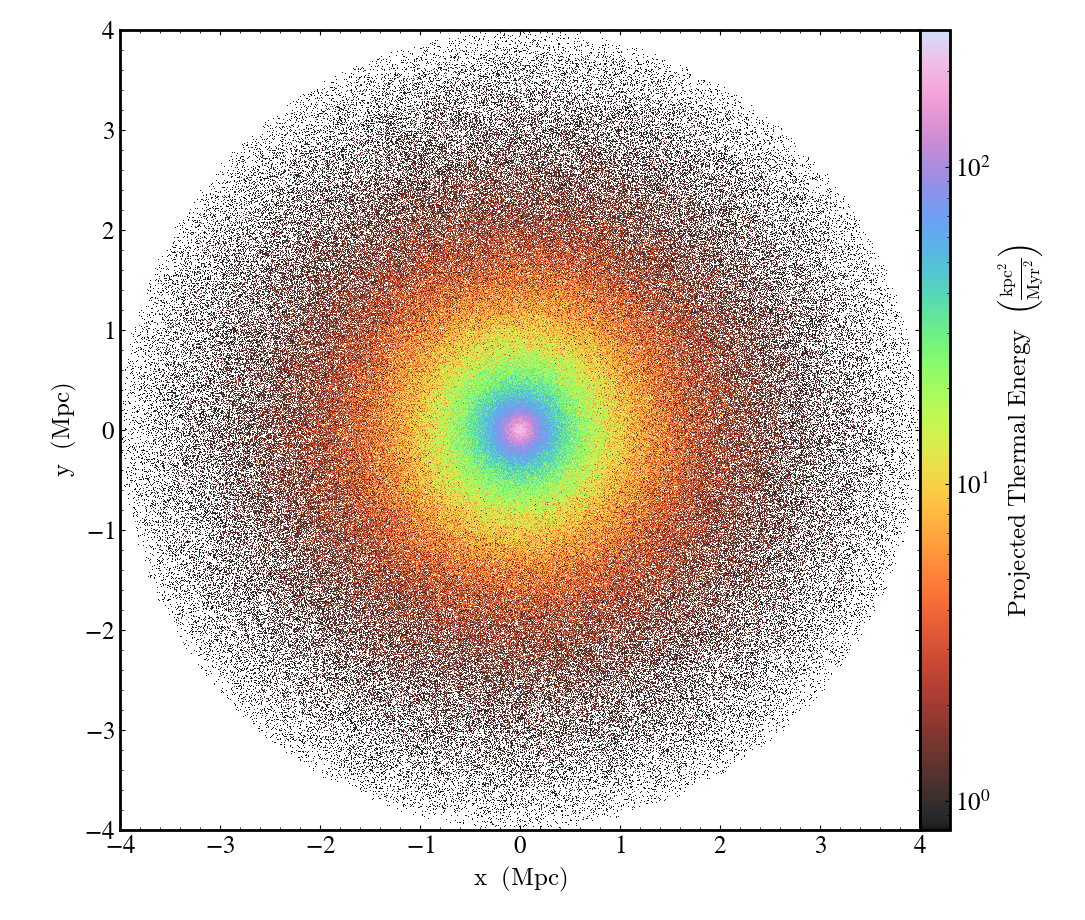

In [20]:
p1.set_cmap(("gas","thermal_energy"),"kamae")
p1.show()

yt : [INFO     ] 2023-08-27 16:28:14,623 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-08-27 16:28:14,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-08-27 16:28:14,627 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-27 16:28:14,629 Parameters: domain_right_edge         = [8000. 8000. 8000.]
yt : [INFO     ] 2023-08-27 16:28:14,631 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-08-27 16:28:14,634 Allocating for 9.22e+05 particles



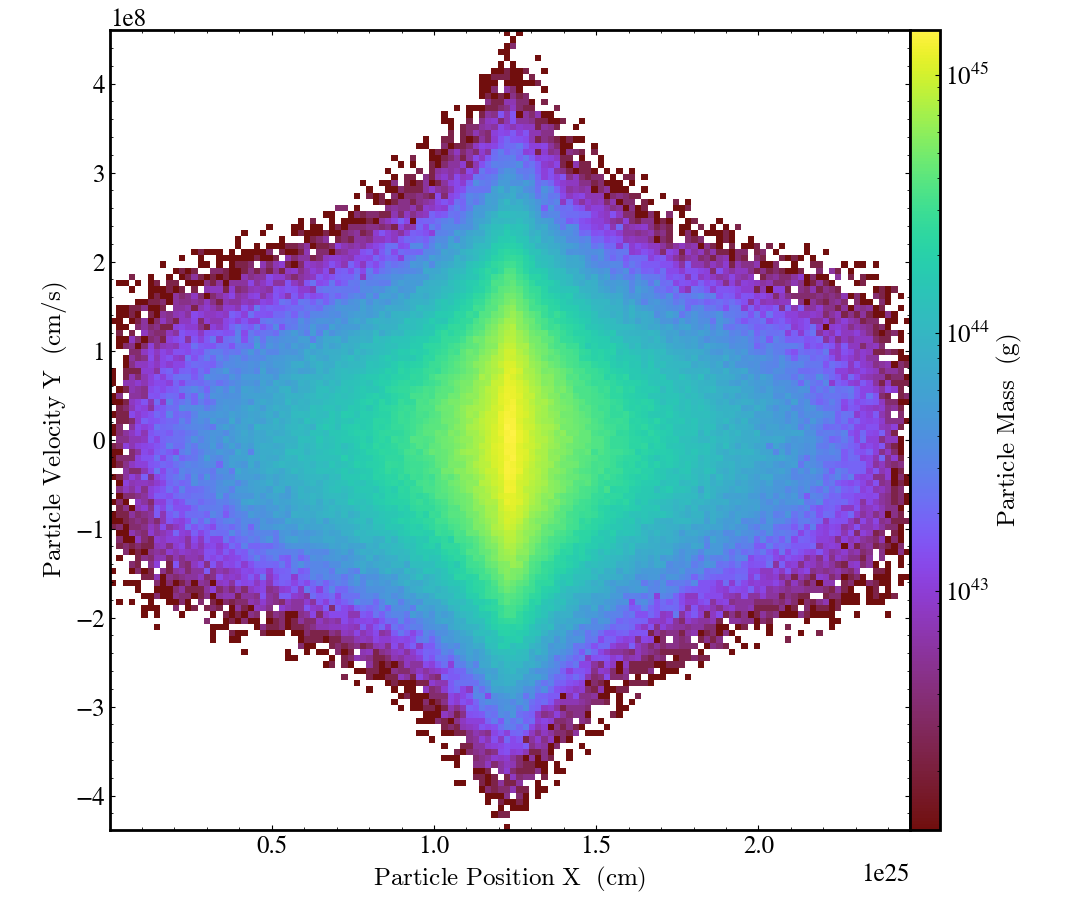

In [21]:
particles.make_radial_cut(4000) # cut at 4000 kpc
particles.add_offsets([4000,4000,4000],[0,0,0]) # move to center of bix

ds2 = particles.to_yt_dataset(box_size=8000)
p2 = yt.PhasePlot(ds2,("all","particle_position_x"),("all","particle_velocity_y"),("all","particle_mass"),weight_field=None)
#p2.set_unit(("gas","particle_position_x"),"kpc")
p2.show()

The final thing worth noting about ``ClusterParticles`` is that we can concatenate them into self consistent systems. Let's see an example with 3 particle sets:

In [22]:
# making the particles #
gas_particles_1 = basic_model.generate_gas_particles(100_000)
gas_particles_2 = basic_model.generate_gas_particles(100_000)
dm_particles = basic_model.generate_dm_particles(100_000)

gas_particles_2.make_radial_cut(5000)
gas_particles_1.make_radial_cut(5000)
dm_particles.make_radial_cut(5000)

cluster_generator : [INFO     ] 2023-08-27 16:28:16,192 We will be assigning 100000 particles.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,193 	Computing particle positions...
cluster_generator : [INFO     ] 2023-08-27 16:28:16,217 Computing particle thermal energies, densities, and masses.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,418 Set particle velocities to zero.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,421 We will be assigning 100000 particles.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,422 	Computing particle positions...
cluster_generator : [INFO     ] 2023-08-27 16:28:16,448 Computing particle thermal energies, densities, and masses.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,654 Set particle velocities to zero.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,657 We will be assigning 100000 dark_matter particles.
cluster_generator : [INFO     ] 2023-08-27 16:28:16,659 Compute 100000 particle positions.
cluster_generator : [INF

Generating particle velocities [LMA]:   0%|          | 0/100000 [00:00<?, ?it/s]

In [23]:
from cluster_generator.particles import concat_clusters
big_system = concat_clusters([gas_particles_2,gas_particles_1,dm_particles],[basic_model,basic_model,basic_model],[[0,0,0],[1000,0,0],[0,0,0]],[[0,0,0],[0,0,0],[-1000,0,0]])

cluster_generator : [INFO     ] 2023-08-27 16:28:17,194 Concatenating 3 clusters.


In [24]:
big_system.add_offsets([8000,8000,8000],[0,0,0])
ds = big_system.to_yt_dataset(16000)

yt : [INFO     ] 2023-08-27 16:28:18,362 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-08-27 16:28:18,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-08-27 16:28:18,368 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-27 16:28:18,370 Parameters: domain_right_edge         = [16000. 16000. 16000.]
yt : [INFO     ] 2023-08-27 16:28:18,372 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2023-08-27 16:28:18,386 Allocating for 3e+05 particles
yt : [INFO     ] 2023-08-27 16:28:18,810 xlim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:18,812 ylim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:18,815 xlim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:18,817 ylim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:18,820 Splatting (('all', 'particle_velocity_x')) onto a 800 by 800 mesh using method 'ngp'



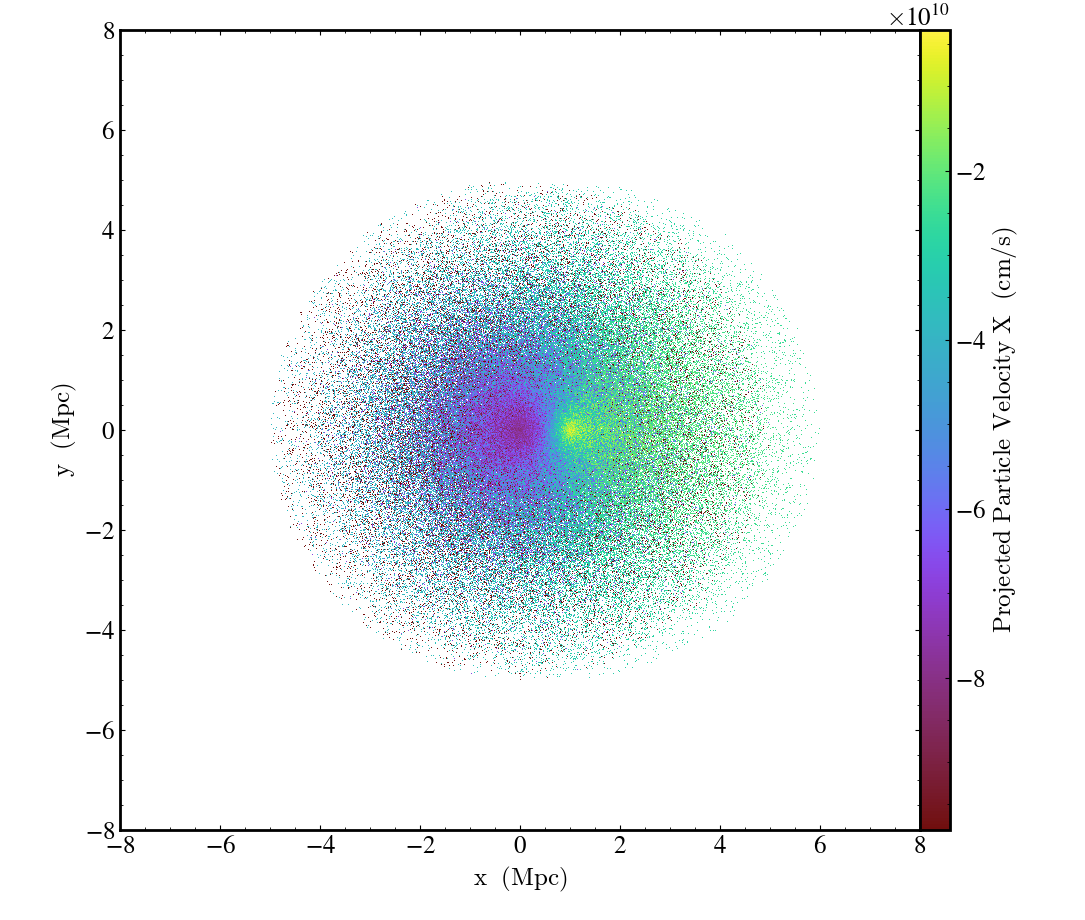

yt : [INFO     ] 2023-08-27 16:28:19,698 xlim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:19,700 ylim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:19,703 xlim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:19,704 ylim = 0.000000 16000.000000
yt : [INFO     ] 2023-08-27 16:28:19,707 Splatting (('gas', 'thermal_energy')) onto a 800 by 800 mesh using method 'ngp'



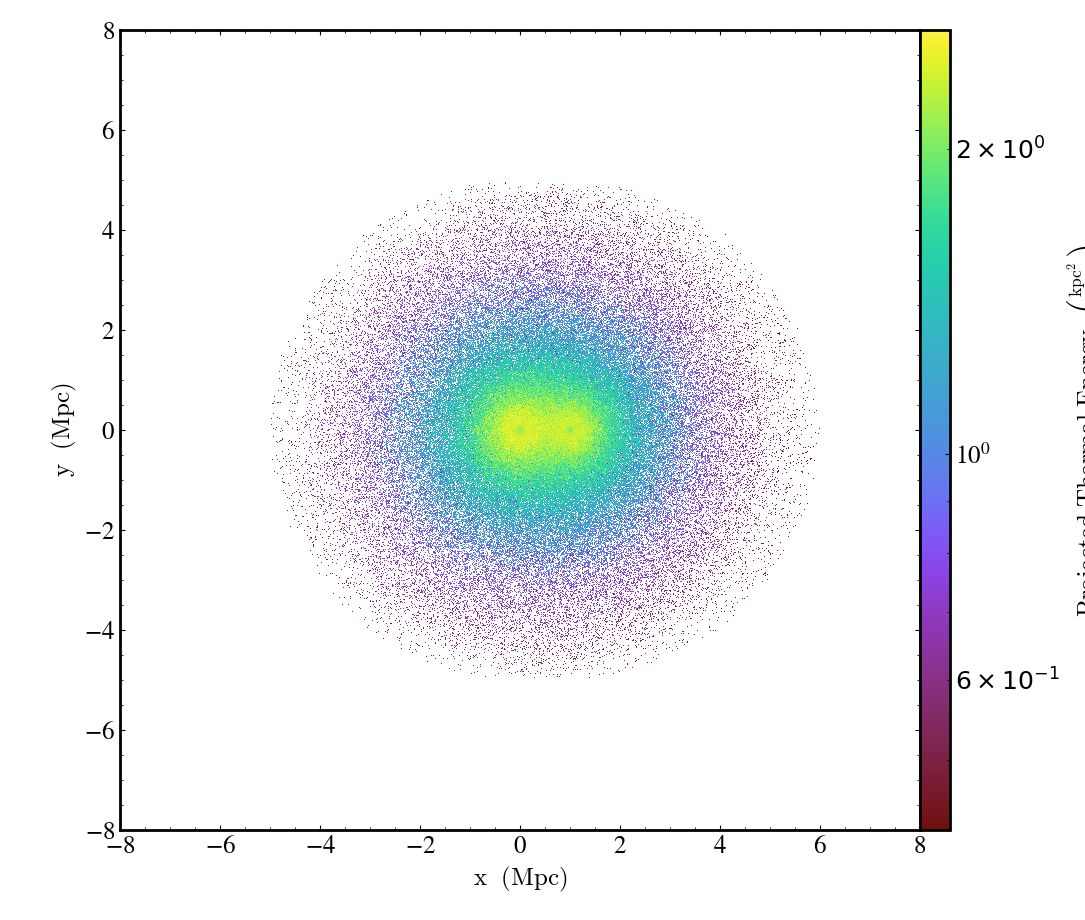

In [25]:
p = yt.ParticlePlot(ds,("all","particle_position_x"),("all","particle_position_y"),("all","particle_velocity_x"),weight_field=("all","particle_ones"))
p.show()
p = yt.ParticlePlot(ds,("gas","particle_position_x"),("gas","particle_position_y"),("gas","thermal_energy"),weight_field=("gas","particle_ones"))
p.show()



### ClusterICs

---

At this point, we've come just about full circle. Generally speaking, this is also the order of construction for initial conditions; ``RadialProfile``'s to ``ClusterModels`` then virialization. But now that we've got our **super-duper amazing galaxy cluster**, we want to study it, or better, smash it into another amazing cluster!

So how do we go about doing that?

The ``ClusterICs`` class is ``cluster_generators`` frontend class and its entire purpose is to facilitate the conversion of our ``ClusterModel`` class into a reasonably constructed, AMR ready initial condition setup that you can go ahead and use! 

#### Inside ClusterICs

Let's dig into these classes. ``ClusterICs`` are essentially a container class for particle objects and ``ClusterModel`` instances. The ``basename`` parameter provides the name of the given initial condition. Let's set one up and see what it looks like:


In [27]:
# -- Getting the profiles ready -- #
basic_model.write_model_to_h5("profile_1.h5",overwrite=True)
basic_model.write_model_to_h5("profile_2.h5",overwrite=True)

ic = cg.ClusterICs("example",
                   2,
                   ["profile_1.h5","profile_2.h5"],
                   [[5000,5000,5000],[10000,5000,5000]],
                   [[1000,0,0],[0,0,0]],
                   {"dm":1_000_000,"star":1_000_000},
                   r_max=5000)

cluster_generator : [INFO     ] 2023-08-27 21:25:15,844 Loading ClusterModel instance from profile_1.h5.


Computing particle DF (Eddington) :   0%|          | 0/10000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-08-27 21:25:40,012 Loading ClusterModel instance from profile_2.h5.


Computing particle DF (Eddington) :   0%|          | 0/10000 [00:00<?, ?it/s]

So we've clearly loaded in a set of ``ClusterModel`` instances and placed them in the ``ClusterICs`` object. The ``ic`` object has several attributes:

In [31]:
for attr in ["particle_files","profiles","num_halos","num_particles","center","velocity","mag_file","r_max"]:
    print(f"{attr} = {getattr(ic,attr)}")

particle_files = [None, None, None]
profiles = ['profile_1.h5', 'profile_2.h5']
num_halos = 2
num_particles = defaultdict(<class 'list'>, {'dm': [500000, 500000], 'gas': [0, 0], 'star': [500000, 500000]})
center = [[ 5000.  5000.  5000.]
 [10000.  5000.  5000.]] kpc
velocity = [[1000.    0.    0.]
 [   0.    0.    0.]] kpc/Myr
mag_file = None
r_max = 5000


So what is all of this? Let's go through it in order:

- ``particle_files``: These are the linked files that store the particle data to prevent the need to regenerate on every load. These can be specified during instantiation, or left as ``None`` to 
  indicate the intention to have them regenerated.
- ``profiles``: These are the paths to the ``ClusterModels`` that make up the system.
- ``num_halos``: this is the number of halos, should match number of profiles.
- ``center`` and ``velocity`` are the relative COM position and velocities for the different components.
- ``mag_file``: If it exists, this is the link to the magnetic field file.
- ``r_max`` the maximal radius at which truncation occurs for each of the components.

So, what can you do with these objects? 

The first useful thing to show is that they can be saved to ``.yaml`` files as follows:

In [33]:
# -- Saving the IC -- #
ic.to_file("basic_ic.yaml",overwrite=True)

with open("basic_ic.yaml","r") as f:
    print(f.read())
    

basename: example  # base name for ICs
num_halos: 2 # Number of halos
num_dm_particles: 1000000 # Number of DM particles
num_star_particles: 1000000 # Number of star particles
r_max: 5000 # Maximal Radius
profile1: profile_1.h5 # profile for cluster 1.
center1: # center for cluster 1.
- 5000.0
- 5000.0
- 5000.0
velocity1: # velocity for cluster 1.
- 1000.0
- 0.0
- 0.0
profile2: profile_2.h5 # profile for cluster 2.
center2: # center for cluster 2.
- 10000.0
- 5000.0
- 5000.0
velocity2: # velocity for cluster 2.
- 0.0
- 0.0
- 0.0


As you can see, this is basically just a directory of basic information about the systems involved, which then have to be loaded individually as well. Generally, there's very little need to actually
access these objects or their underlying methods. Instead these act as the basis for the ``codes`` module, which provides all of the necessary procedures for generating purpose built ICs. For more information on actually generating ICs for each of the available codes, see the codes example book.